Before cleaning:


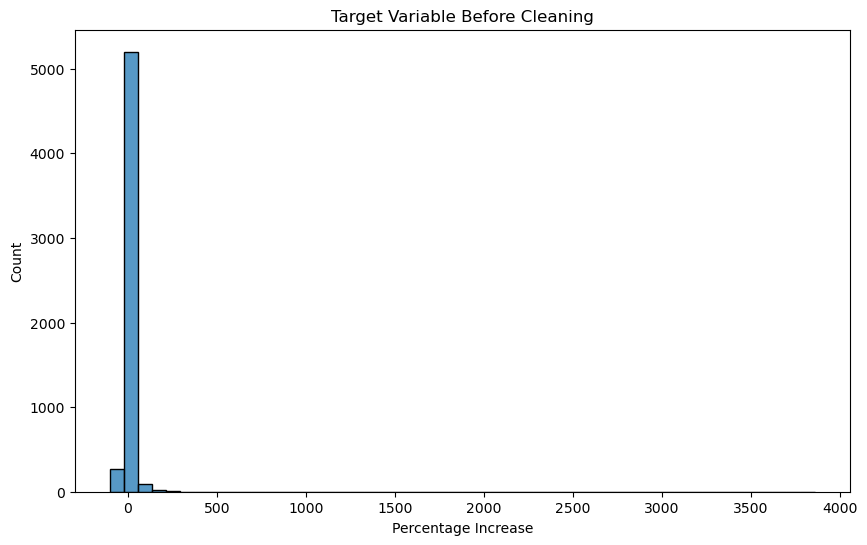

Target variable statistics:
Mean: inf
Median: 10.1228
Std: nan
Min: -100.0000
Max: inf

After cleaning:


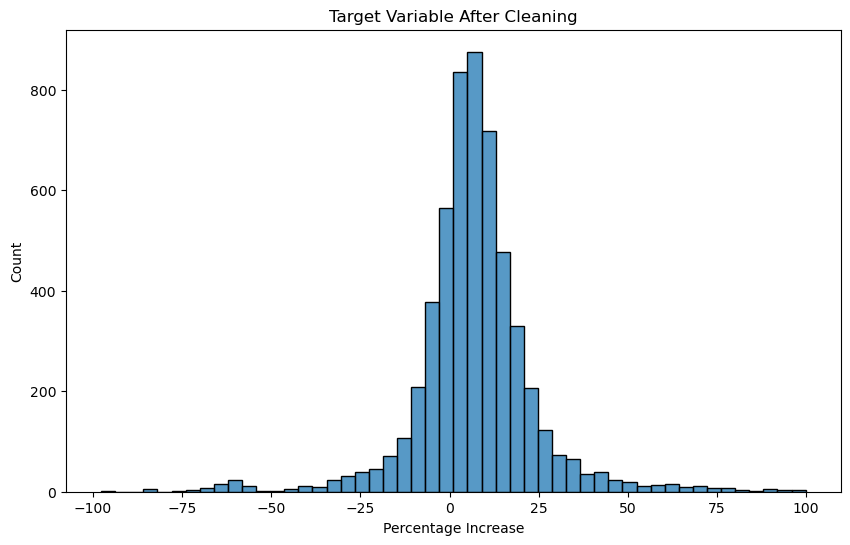

Target variable statistics:
Mean: 6.9283
Median: 6.5088
Std: 17.1871
Min: -97.7191
Max: 99.8548

Top selected features:
- Licensed_Beds
- Acute_Care_Other_Discharges
- Acute_Care_Total_Discharges
- Total_Medicaid_Discharges
- Total_Other_Discharges
- Total_Discharges
- Swing_Bed_Other_Patient_Days
- SNF_Other_Patient_Days
- Total_Patient_Days
- Total_Births
- Total_Newborn_Days
- Acute_Medicare_Inpatient_Revenue
- Acute_Total_Inpatient_Revenue
- SNF_Other_Revenue
- Acute_Contractuals_Medicare
- Total_Medicare_Contractuals
- Total_Contractuals
- All_Other_Expenses
- Net_Non_Operating_Gains_Losses
- Gross_Total_Margin

--- Training SVM Model ---

SVM Model Performance:
Mean Squared Error: 317.4120
R-squared Score: -0.0305

--- Training Linear Regression Model ---

Linear Regression Model Performance:
Mean Squared Error: 302.3384
R-squared Score: 0.0184


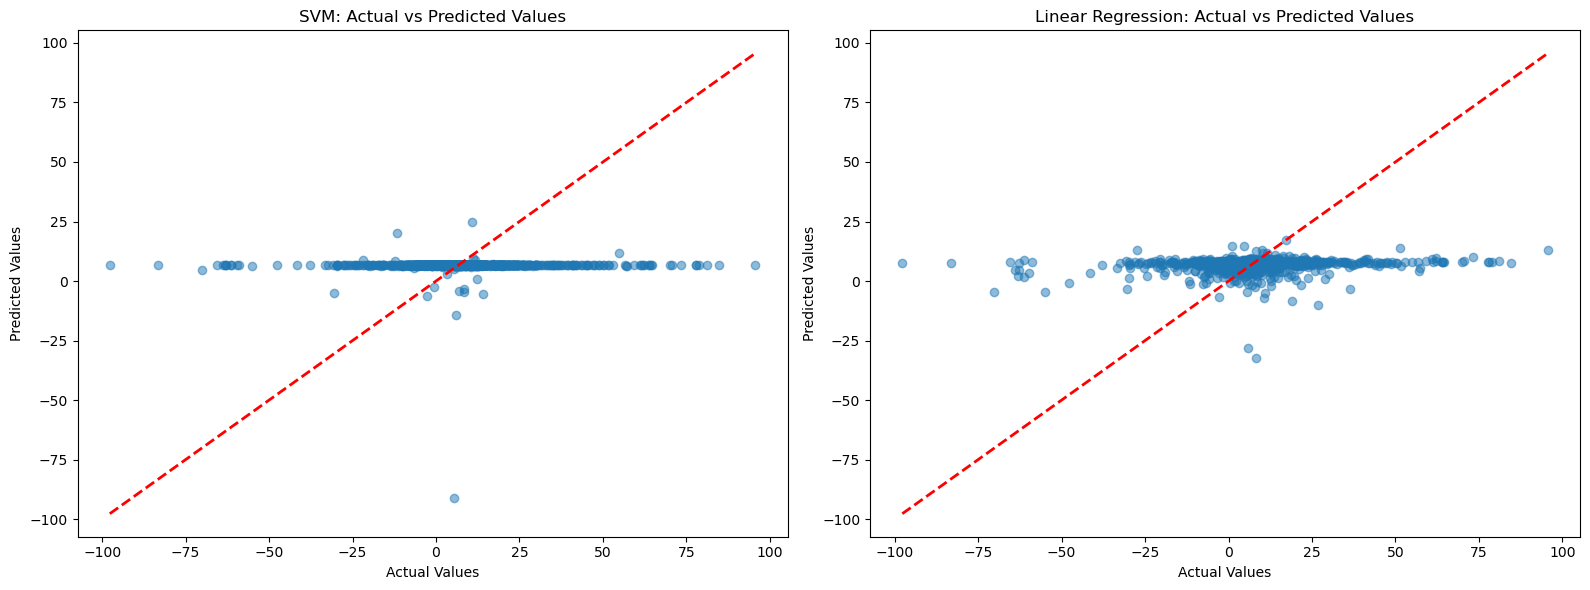

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('C:/school/labs')
df = pd.read_csv('oregon_washington_combined_data.csv')

def analyze_target_distribution(y, title='Distribution of Target Variable'):
    plt.figure(figsize=(10, 6))
    sns.histplot(y, bins=50)
    plt.title(title)
    plt.xlabel('Percentage Increase')
    plt.ylabel('Count')
    plt.show()
    
    print(f"Target variable statistics:")
    print(f"Mean: {y.mean():.4f}")
    print(f"Median: {y.median():.4f}")
    print(f"Std: {y.std():.4f}")
    print(f"Min: {y.min():.4f}")
    print(f"Max: {y.max():.4f}")

def preprocess_data(df):
    columns_to_drop = ['Hospital_License_or_AHA', 'Hospital_Name', 'Year', 'Quarter', 'State']
    df = df.drop(columns=columns_to_drop)
    
    # Handle missing values
    df = df.fillna(df.mean())
    
    X = df.drop('Pct_Inc_Total_Revenue_Next_Year', axis=1)
    y = df['Pct_Inc_Total_Revenue_Next_Year']
    
    return X, y

def select_features(X, y, k=20):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)
    
    selected_features = X.columns[selector.get_support()].tolist()
    print("\nTop selected features:")
    for feature in selected_features:
        print(f"- {feature}")
    
    return X_selected, selected_features

def train_svm_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features using 
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Scale the target variable
    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    
    # Create and train a SVR model 
    svm_model = SVR(
        kernel='rbf',
        C=10.0,
        epsilon=0.01,
        gamma='scale'
    )
    svm_model.fit(X_train_scaled, y_train_scaled)
    
    y_pred_scaled = svm_model.predict(X_test_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return svm_model, scaler, mse, r2, y_test, y_pred

def train_linear_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train a Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    y_pred = lr_model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return lr_model, scaler, mse, r2, y_test, y_pred

def plot_actual_vs_predicted(y_test, svm_pred, lr_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # SVM Plot
    ax1.scatter(y_test, svm_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('SVM: Actual vs Predicted Values')
    
    # Linear Regression Plot
    ax2.scatter(y_test, lr_pred, alpha=0.5)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.set_title('Linear Regression: Actual vs Predicted Values')
    
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    X, y = preprocess_data(df)

    # Analyze target distribution before cleaning
    print('Before cleaning:')
    analyze_target_distribution(y, title='Target Variable Before Cleaning')

    # Remove rows where the target is not finite or is an extreme outlier
    mask = np.isfinite(y) & (~y.isna()) & (np.abs(y) < 100)  
    X = X[mask]
    y = y[mask]

    print('\nAfter cleaning:')
    analyze_target_distribution(y, title='Target Variable After Cleaning')

    # Remove leaky features
    leaky_features = ['Next_Year_Total_Revenue', 'Total_Revenue']
    X = X.drop(columns=[f for f in leaky_features if f in X.columns])

    # Select most important features
    X_selected, selected_features = select_features(X, y, k=20)
    
    # Train the SVM model with StandardScaler on target
    print("\n--- Training SVM Model ---")
    svm_model, svm_scaler, svm_mse, svm_r2, y_test, svm_y_pred = train_svm_model(X_selected, y)
    
    print("\nSVM Model Performance:")
    print(f"Mean Squared Error: {svm_mse:.4f}")
    print(f"R-squared Score: {svm_r2:.4f}")

    # Train the Linear Regression baseline model
    print("\n--- Training Linear Regression Model ---")
    lr_model, lr_scaler, lr_mse, lr_r2, _, lr_y_pred = train_linear_model(X_selected, y)

    print("\nLinear Regression Model Performance:")
    print(f"Mean Squared Error: {lr_mse:.4f}")
    print(f"R-squared Score: {lr_r2:.4f}")
    
    # Create the actual vs predicted plots
    plot_actual_vs_predicted(y_test, svm_y_pred, lr_y_pred)

if __name__ == "__main__":
    main() 